In [2]:
import os
import sys
os.getcwd()
os.chdir('/gpfs/space/home/joonas97/KITSCAM')

In [5]:
import torch
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import os
import torch.nn.functional as F

from ScoreCAM.utils import *
from ScoreCAM.cam.scorecam import *
from utils import CustomDataset

In [3]:
sys.path.append('/gpfs/space/home/joonas97/KITSCAM/ScoreCAM')

In [4]:
os.getcwd()

'/gpfs/space/home/joonas97/KITSCAM'

In [6]:
torch.cuda.is_available()

True

## Load the validation dataset

In [7]:
data_dir = '/gpfs/space/home/joonas97/data/kits21/processed_2d_slices/val/for_scorecam'

#train_dataset = CustomDataset(os.path.join(data_dir, "train"))

val_dataset = CustomDataset(data_dir)


data loaded
Shape:  (3998, 512, 512)
calculating mean and std
std and mu calculated


In [8]:
len(val_dataset)

3998

## Load segmentatation maps

In [9]:
seg_maps = np.load(
    '/gpfs/space/home/joonas97/data/kits21/processed_2d_slices/segmentations/segmentation_dataset_scorecam.npy')

In [40]:
np.unique(seg_maps[100], return_counts=True)

(array([0., 1., 2.]), array([253885,   7533,    726]))

In [11]:
seg_maps.shape

(3998, 512, 512)

## Load trained model (based on resnet50)

In [12]:
os.chdir('/gpfs/space/home/joonas97/KITSCAM')
resnet = models.resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet.load_state_dict(torch.load('trained_resnet'))
resnet.eval()

resnet_model_dict = dict(type='resnet50', arch=resnet, layer_name='layer4', input_size=(512, 512))
resnet_scorecam = ScoreCAM(resnet_model_dict)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import *

discrete_cmap = ListedColormap(['#53c972', '#e3c634', '#2a5fbd'])
discrete_cmap.set_under(color='white', alpha=0)
boundaries = [0.1, 1.1, 2.1, 3.1]
norm = BoundaryNorm(boundaries, discrete_cmap.N)

In [48]:
indexes = []
first_scorecam = True
for i in tqdm(np.arange(3998)):
    input_image = val_dataset[i][0].float().unsqueeze(0)

    if torch.cuda.is_available():
        input_image = input_image.cuda()
    predicted_class = resnet(input_image).max(1)[-1]
    if predicted_class == 1:
        indexes.append(i)
        if first_scorecam:
            scorecams = resnet_scorecam(input_image)
            scorecams = scorecams[0].cpu().detach().numpy()
            first_scorecam = False
        else:
            scorecams = np.concatenate((scorecams, resnet_scorecam(input_image)[0].cpu().detach().numpy()), axis=0)

np.save("predicted_slices_with_kindey", np.array(indexes))
np.save("cam_maps", scorecams)

  0%|          | 0/3998 [00:00<?, ?it/s]/gpfs/space/home/joonas97/KITSCAM/ScoreCAM/cam/scorecam.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)
  0%|          | 3/3998 [00:54<20:18:06, 18.29s/it]


KeyboardInterrupt: 

In [44]:
scorecams.shape

(3, 512, 512)

## Get saliency maps and visualize them 

tensor([0], device='cuda:0')


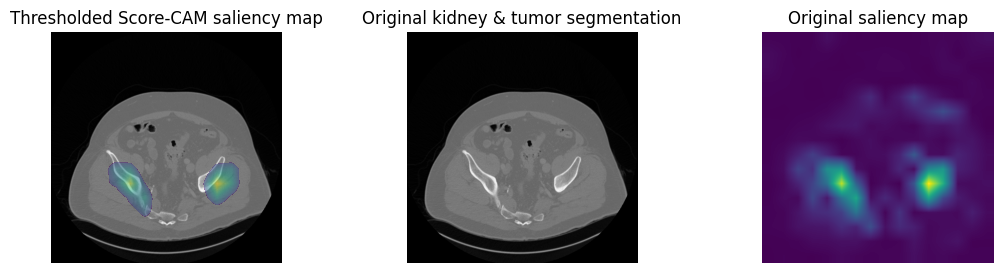

tensor([1], device='cuda:0')


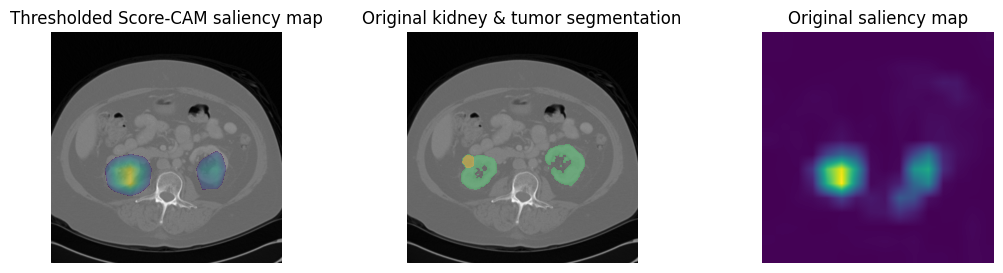

tensor([0], device='cuda:0')


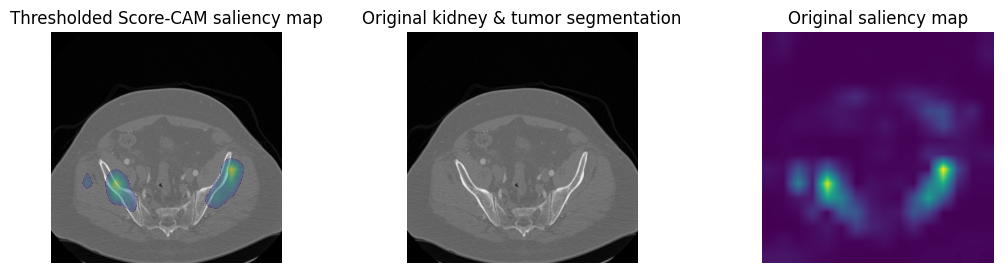

tensor([1], device='cuda:0')


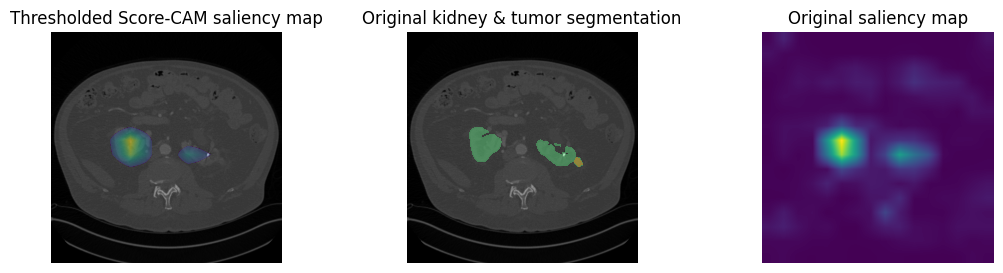

tensor([0], device='cuda:0')


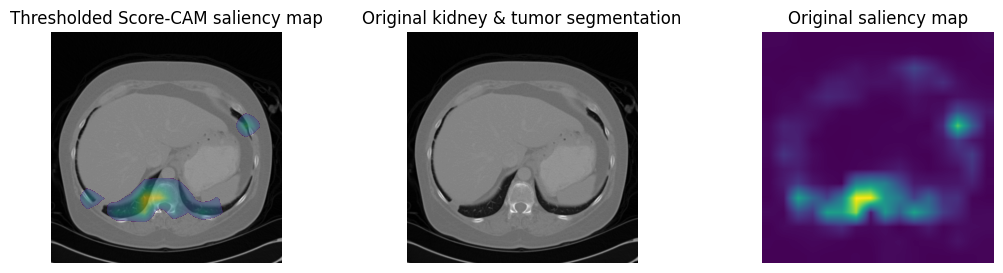

In [16]:
# for i in np.random.choice(np.arange(3998),5, replace = False):
for i in np.arange(3998):
    input_image = val_dataset[i][0].float().unsqueeze(0)

    if torch.cuda.is_available():
        input_image = input_image.cuda()
    predicted_class = resnet(input_image).max(1)[-1]
    if predicted_class == 1:
        scorecam_map = resnet_scorecam(input_image)

    threshold = .3

    # create thresholded saliency map
    thresholded_attention = torch.zeros_like(scorecam_map)
    mask = scorecam_map >= threshold
    thresholded_attention[mask] = scorecam_map[mask]

    fig = plt.figure(figsize=(13, 3))
    ax = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    ax.imshow(input_image[0, 0].cpu(), cmap='gray')
    cmap = plt.get_cmap('viridis')
    cmap.set_under(color='white', alpha=0)
    ax.imshow(thresholded_attention[0, 0].type(torch.FloatTensor).cpu(), cmap=cmap, alpha=0.5, vmin=0.1)
    ax.set_title("Thresholded Score-CAM saliency map")
    ax.set_axis_off()

    ax2.imshow(input_image[0, 0].cpu(), cmap='gray')
    ax2.imshow(seg_maps[i], alpha=0.5, cmap=discrete_cmap, norm=norm)
    ax2.set_title("Original kidney & tumor segmentation")
    ax2.set_axis_off()

    ax3.imshow(scorecam_map[0, 0].cpu(), cmap='viridis')
    ax3.set_title("Original saliency map")
    ax3.set_axis_off()
    #plt.savefig("figs/2d_cam_fig_nr"+str(i))
    plt.show()


In [19]:
predicted_class == 0

tensor([True], device='cuda:0')

/gpfs/space/home/joonas97/.conda/envs/KITSCAM/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/gpfs/space/home/joonas97/kitscam/Score-CAM/cam/scorecam.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logit = F.softmax(logit)
/gpfs/space/home/joonas97/kitscam/Score-CAM/cam/scorecam.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


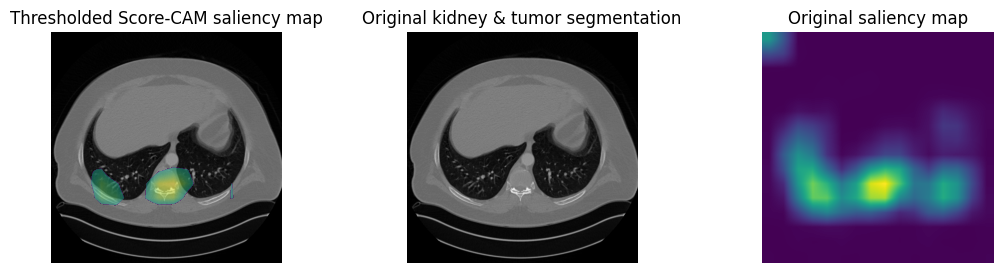

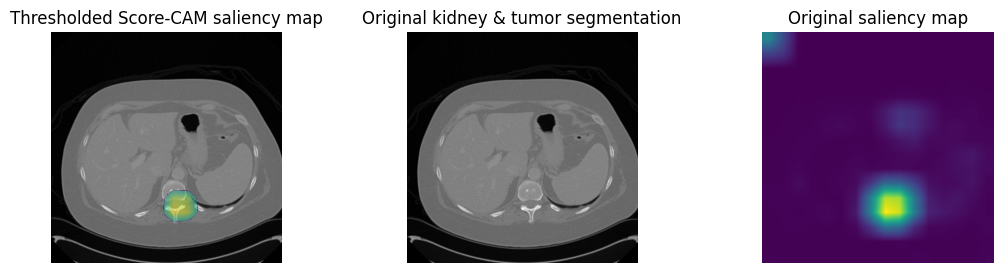

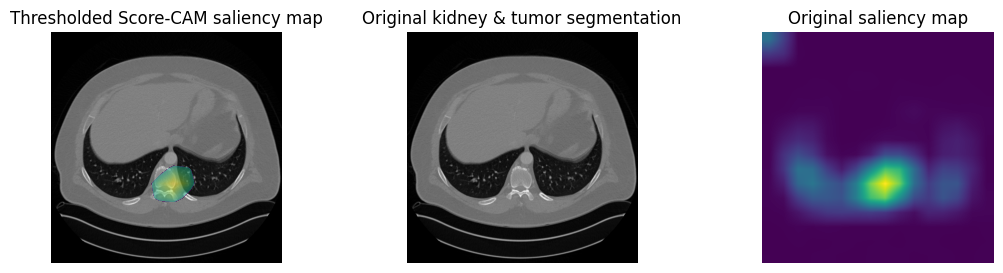

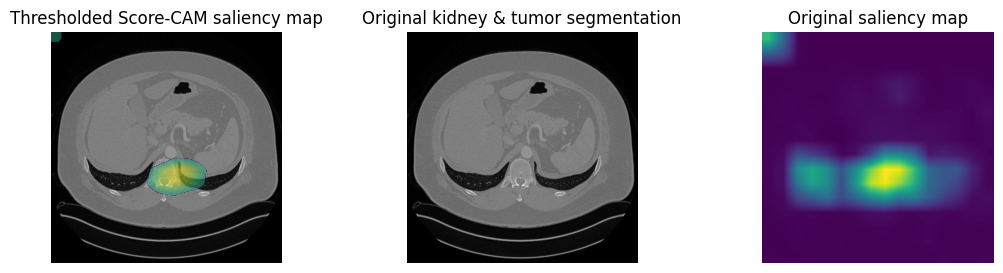

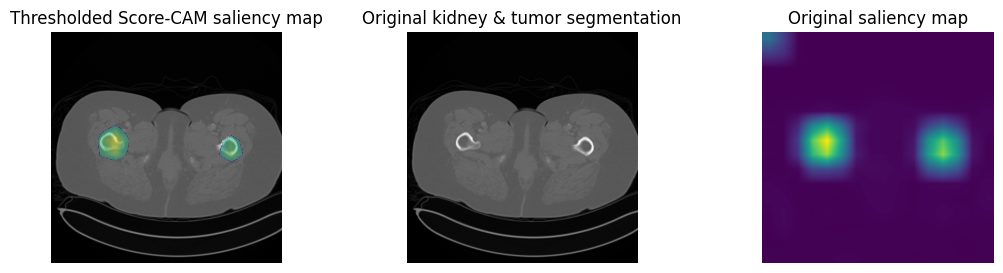

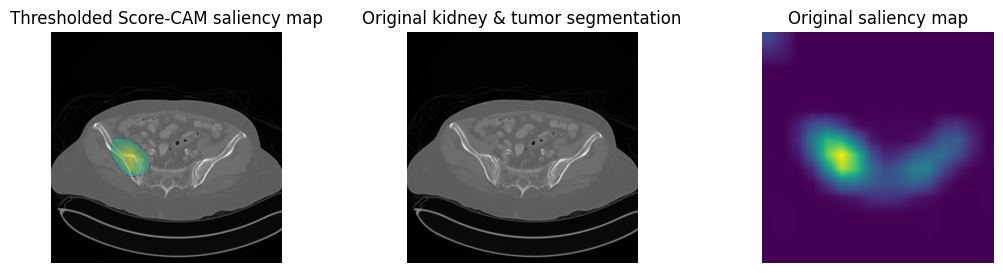

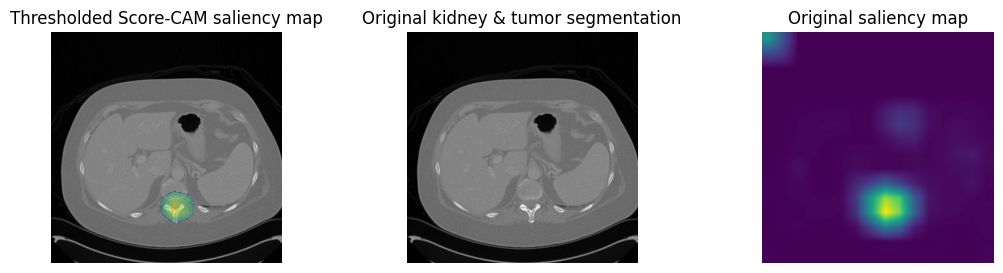

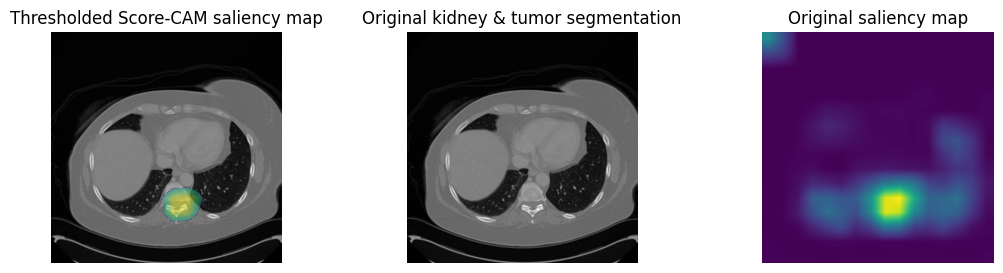

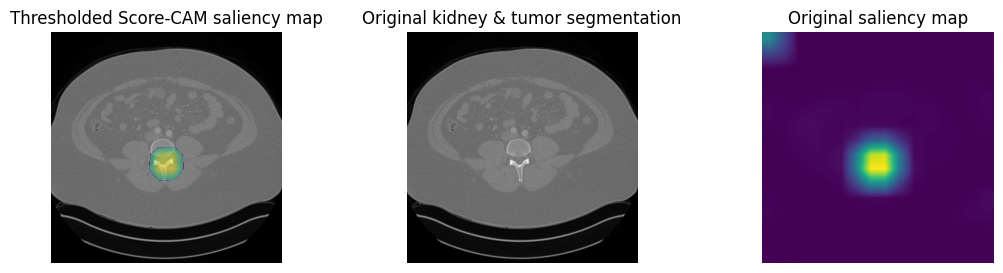

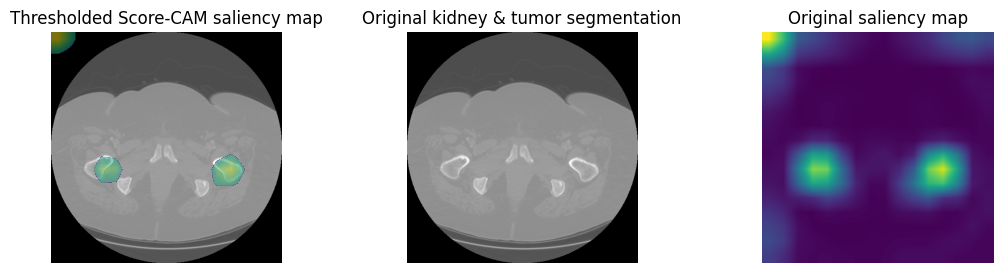

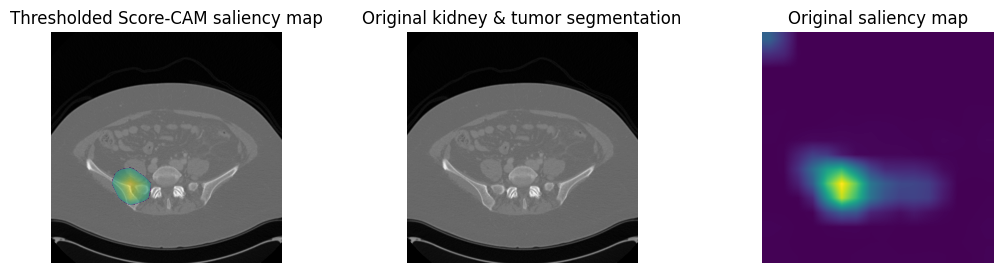

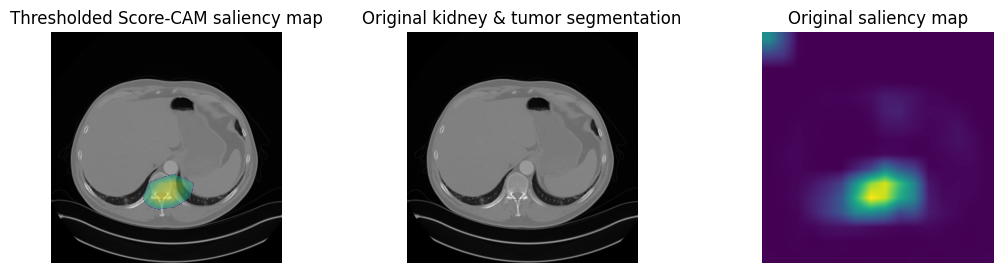

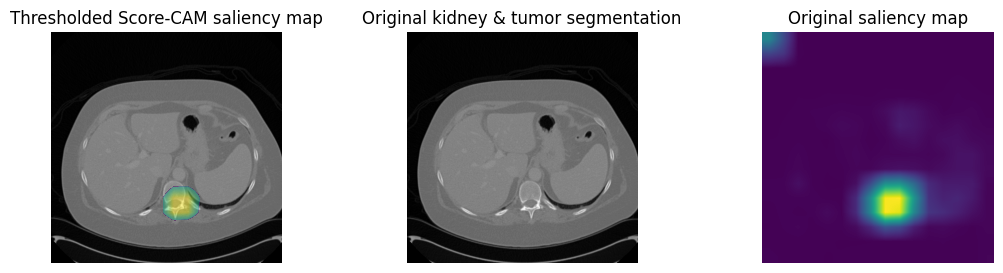

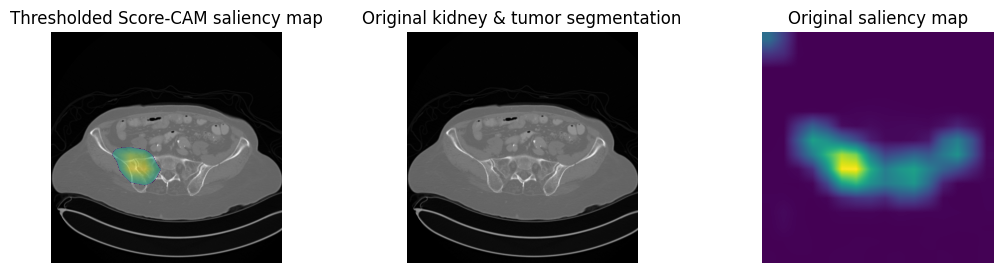

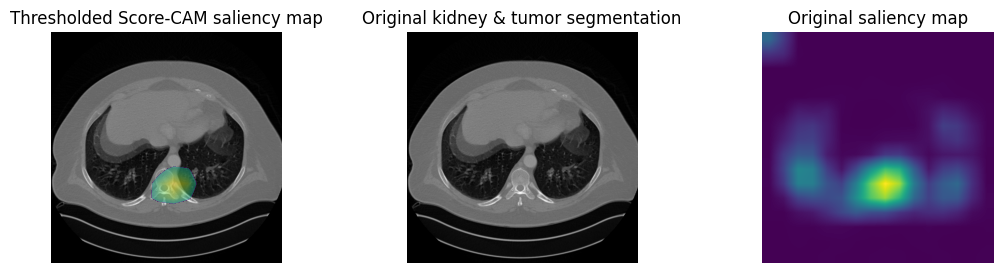

In [12]:
for i in np.random.choice(np.arange(764, 1528), 15, replace=False):
    input_image = val_dataset[i][0].float().unsqueeze(0)

    if torch.cuda.is_available():
        input_image = input_image.cuda()
    predicted_class = resnet(input_image).max(1)[-1]

    scorecam_map = resnet_scorecam(input_image)

    threshold = .6

    # create thresholded saliency map
    thresholded_attention = torch.zeros_like(scorecam_map)
    mask = scorecam_map >= threshold
    thresholded_attention[mask] = scorecam_map[mask]

    fig = plt.figure(figsize=(13, 3))
    ax = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    ax.imshow(input_image[0, 0].cpu(), cmap='gray')
    cmap = plt.get_cmap('viridis')
    cmap.set_under(color='white', alpha=0)
    ax.imshow(thresholded_attention[0, 0].type(torch.FloatTensor).cpu(), cmap=cmap, alpha=0.5, vmin=0.1)
    ax.set_title("Thresholded Score-CAM saliency map")
    ax.set_axis_off()

    ax2.imshow(input_image[0, 0].cpu(), cmap='gray')
    ax2.imshow(seg_maps[i], alpha=0.5, cmap=discrete_cmap, norm=norm)
    ax2.set_title("Original kidney & tumor segmentation")
    ax2.set_axis_off()

    ax3.imshow(scorecam_map[0, 0].cpu())
    ax3.set_title("Original saliency map")
    ax3.set_axis_off()
    plt.savefig("figs/2d_cam_no_kidney_fig_nr" + str(i))
    plt.show()


In [119]:
masked_data = np.random.random((100, 100))
masked_data = np.ma.masked_where(masked_data < 0.9, masked_data)

In [120]:
masked_data

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., 0.9722479246638546, --, --],
        [--, --, --, ..., 0.9309489644337382, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, 0.959493250880919]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True, False]],
  fill_value=1e+20)

In [136]:
np.random.choice(np.arange(764, 1528), 25, replace=False)

array([1354,  970, 1526, 1287, 1138, 1182, 1197, 1128,  903, 1476, 1126,
       1282, 1342,  947, 1293,  936, 1208,  772, 1232,  922, 1056, 1195,
        931, 1114, 1514])

In [135]:
len(val_dataset)

1528

In [ ]:
import torch

In [ ]:
cu